In [2]:
#make velocity traces for every session
import sys
sys.path.append('../../../src/')

import os
from typing import Dict
from os import PathLike
from pathlib import Path
import csv 

from aind_vr_foraging_analysis import utils
from aind_vr_foraging_analysis.utils import parse, processing, plotting_utils as plotting, AddExtraColumns

# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.backends.backend_pdf import PdfPages

import seaborn as sns
import pandas as pd
import numpy as np
import datetime

sns.set_context('notebook')

import warnings
pd.options.mode.chained_assignment = None  # Ignore SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

import ipywidgets as widgets
from IPython.display import display
from matplotlib.patches import Rectangle
from scipy.signal import find_peaks, butter, lfilter


colors = sns.color_palette()
odor_list_color = [colors[8], colors[0], colors[2], colors[4]]

base_path = r'/Volumes/aind/scratch/vr-foraging/data'
foraging_figures = r'/Users/marinag/Documents/Analysis/NoveltyExploration'

from scipy.optimize import curve_fit
import glob


### Make some fun plots

In [3]:
#read in the data in /Users/nehal.ajmal/Downloads/merged_filtered_df.csv
data = pd.read_csv('/Users/nehal.ajmal/Documents/aindproject/results2/all_peaks_data_first_10.csv')

In [4]:
data.columns

Index(['session', 'odor_label', 'odor_site', 'peak_count', 'peak_frequency',
       'epoch_duration', 'peak_count_after_1s', 'session_type', 'mouse_id'],
      dtype='object')

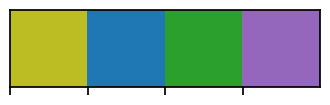

In [5]:
colors = sns.color_palette()
odor_list_color = [colors[8], colors[0], colors[2], colors[4]]
sns.palplot(odor_list_color)

In [6]:
data.odor_label.unique()

#replace Nan with 'NULL'
data['odor_label'] = data['odor_label'].replace(np.nan, 'NULL')
data


,session,odor_label,odor_site,peak_count,peak_frequency,epoch_duration,peak_count_after_1s,session_type,mouse_id
0,745300_20240731T091738,NULL,0.0,31,8.066598,3.843008,7,session_1,745300
1,745300_20240731T091738,NULL,2.0,30,7.806385,3.843008,7,session_1,745300
2,745300_20240731T091738,NULL,4.0,18,4.683831,3.843008,6,session_1,745300
3,745300_20240731T091738,NULL,5.0,20,5.204257,3.843008,6,session_1,745300
4,745300_20240731T091738,NULL,6.0,12,3.122554,3.843008,5,session_1,745300
...,...,...,...,...,...,...,...,...,...
753,717716_20240803T105420,ODOR_C,46.0,12,7.782020,1.542016,8,session_5,717716
754,717716_20240803T105420,ODOR_C,51.0,11,7.133519,1.542016,7,session_5,717716
755,717716_20240803T105420,ODOR_C,65.0,11,7.133519,1.542016,7,session_5,717716
756,717716_20240803T105420,ODOR_C,77.0,12,7.782020,1.542016,8,session_5,717716


In [7]:
#remove all session_0
data = data[data['session'] != 'session_0']
data

,session,odor_label,odor_site,peak_count,peak_frequency,epoch_duration,peak_count_after_1s,session_type,mouse_id
0,745300_20240731T091738,NULL,0.0,31,8.066598,3.843008,7,session_1,745300
1,745300_20240731T091738,NULL,2.0,30,7.806385,3.843008,7,session_1,745300
2,745300_20240731T091738,NULL,4.0,18,4.683831,3.843008,6,session_1,745300
3,745300_20240731T091738,NULL,5.0,20,5.204257,3.843008,6,session_1,745300
4,745300_20240731T091738,NULL,6.0,12,3.122554,3.843008,5,session_1,745300
...,...,...,...,...,...,...,...,...,...
753,717716_20240803T105420,ODOR_C,46.0,12,7.782020,1.542016,8,session_5,717716
754,717716_20240803T105420,ODOR_C,51.0,11,7.133519,1.542016,7,session_5,717716
755,717716_20240803T105420,ODOR_C,65.0,11,7.133519,1.542016,7,session_5,717716
756,717716_20240803T105420,ODOR_C,77.0,12,7.782020,1.542016,8,session_5,717716


# average epoch duration

In [8]:
summary_peaks_df = pd.DataFrame(data)

# Group by mouse_id, session_type, and odor_label, then calculate the mean epoch_duration
average_epoch_duration = summary_peaks_df.groupby(['mouse_id', 'session_type', 'odor_label'])['epoch_duration'].mean().reset_index()

# Rename the column for clarity
average_epoch_duration.rename(columns={'epoch_duration': 'average_epoch_duration'}, inplace=True)

print(average_epoch_duration)



    mouse_id session_type odor_label  average_epoch_duration
0     717716    session_0       NULL                4.842016
1     717716    session_1       NULL                1.258976
2     717716    session_1     ODOR_A                1.226016
3     717716    session_2       NULL                0.984000
4     717716    session_2     ODOR_A                1.026016
..       ...          ...        ...                     ...
78    745306    session_4     ODOR_C                8.948992
79    745306    session_5       NULL                2.792000
80    745306    session_5     ODOR_A                2.775008
81    745306    session_5     ODOR_B                2.359008
82    745306    session_5     ODOR_C                3.016992

[83 rows x 4 columns]


In [9]:
#look at just where mouse_id  = 717716
data_717716 = average_epoch_duration[average_epoch_duration['mouse_id'] == 717716]
data_717716

data_717717 = average_epoch_duration[average_epoch_duration['mouse_id'] == 717717]
data_717717

data_745300 = average_epoch_duration[average_epoch_duration['mouse_id'] == 745300]
data_745300

data_745301 = average_epoch_duration[average_epoch_duration['mouse_id'] == 745301]
data_745301

data_745305 = average_epoch_duration[average_epoch_duration['mouse_id'] == 745305]
data_745305

data_745306 = average_epoch_duration[average_epoch_duration['mouse_id'] == 745306]
data_745306


,mouse_id,session_type,odor_label,average_epoch_duration
69,745306,session_0,NULL,3.709024
70,745306,session_2,NULL,4.544000
71,745306,session_2,ODOR_A,7.544992
72,745306,session_3,NULL,3.650016
73,745306,session_3,ODOR_A,4.741984
74,745306,session_3,ODOR_B,10.509024
75,745306,session_4,NULL,4.805024
76,745306,session_4,ODOR_A,3.274016
77,745306,session_4,ODOR_B,3.008000
78,745306,session_4,ODOR_C,8.948992


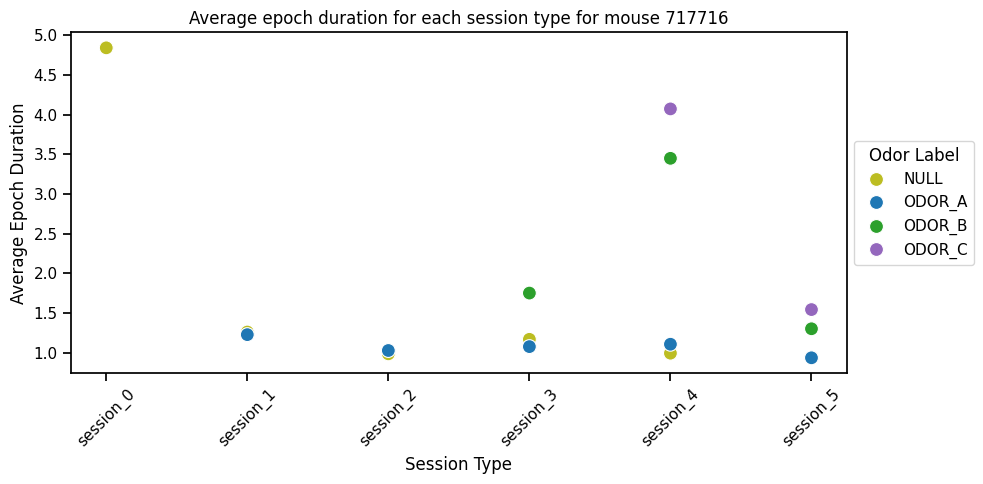

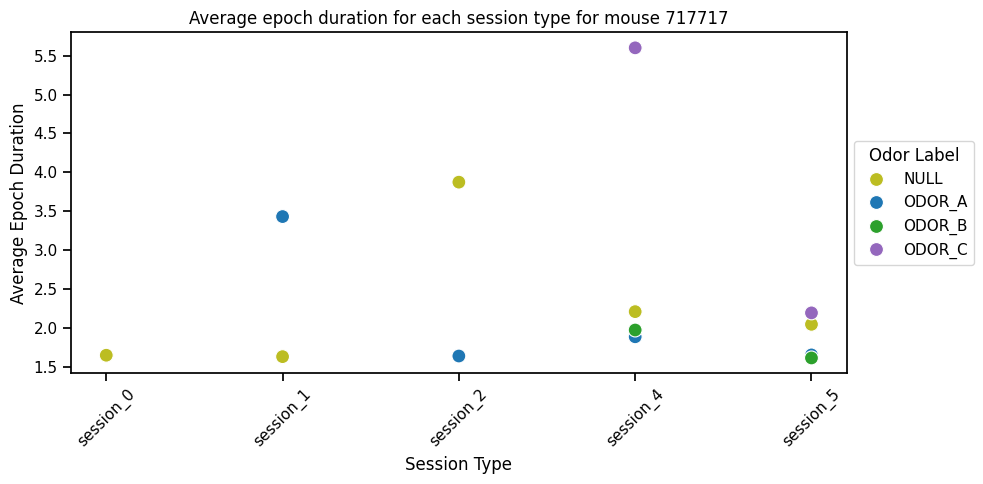

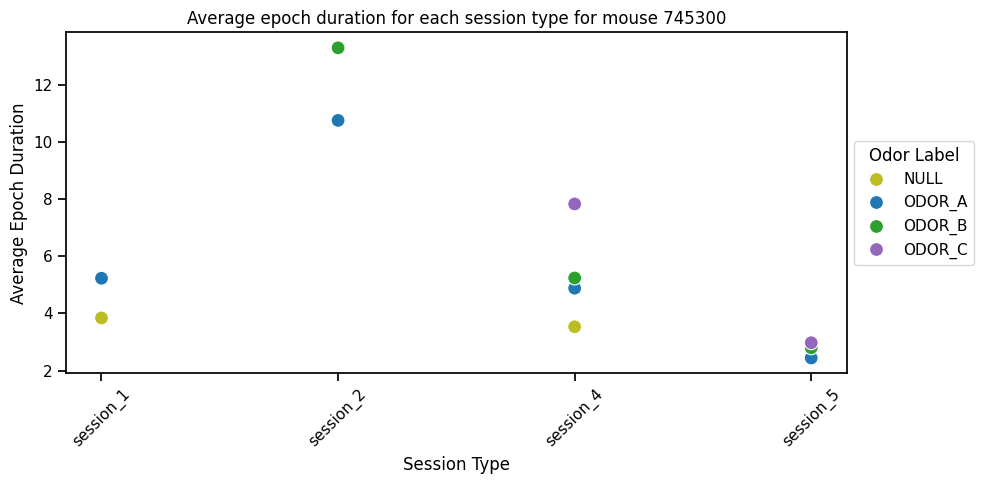

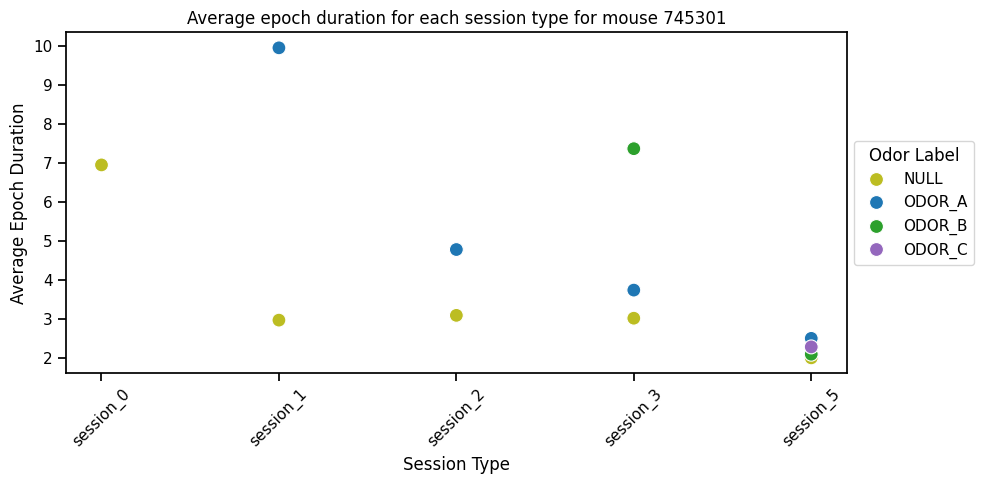

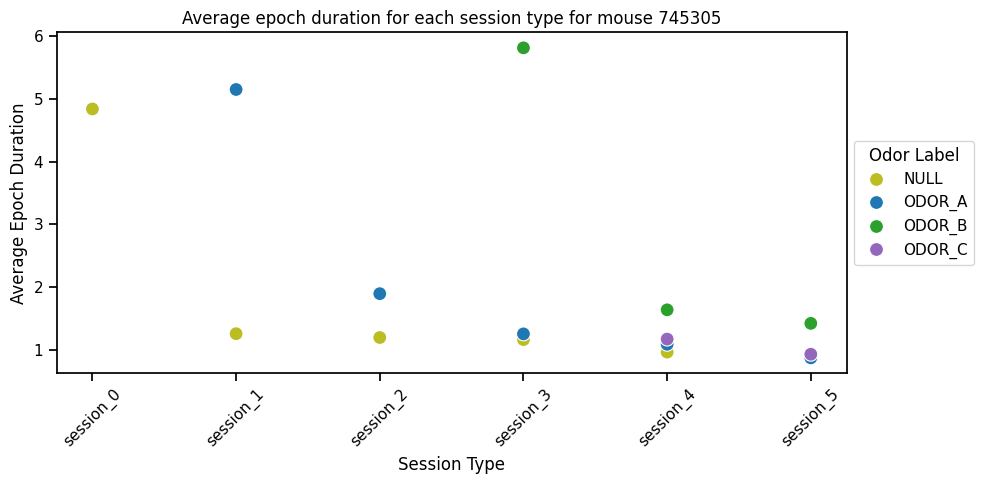

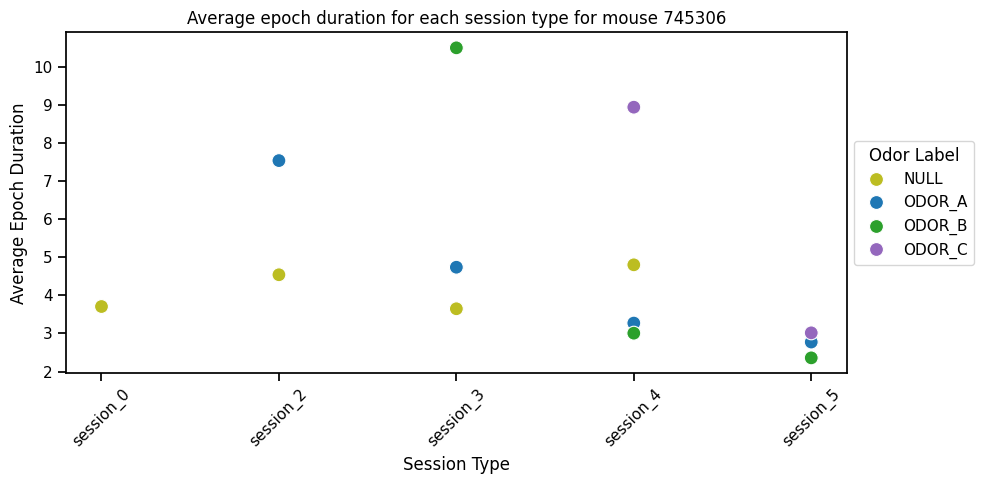

In [10]:

#list of all df
mouse_dfs = [data_717716, data_717717, data_745300, data_745301, data_745305, data_745306]


#plot scatterplot for each mouse, add lines connecting the same odor label
for df in mouse_dfs:
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.scatterplot(data=df, x='session_type', y='average_epoch_duration', hue='odor_label', palette=odor_list_color, s=100)
    plt.title(f"Average epoch duration for each session type for mouse {df['mouse_id'].iloc[0]}")
    plt.xlabel('Session Type')
    plt.ylabel('Average Epoch Duration')
    plt.xticks(rotation=45)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Odor Label')
    plt.tight_layout()
    plt.grid(False)
    plt.show()
    plt.close()


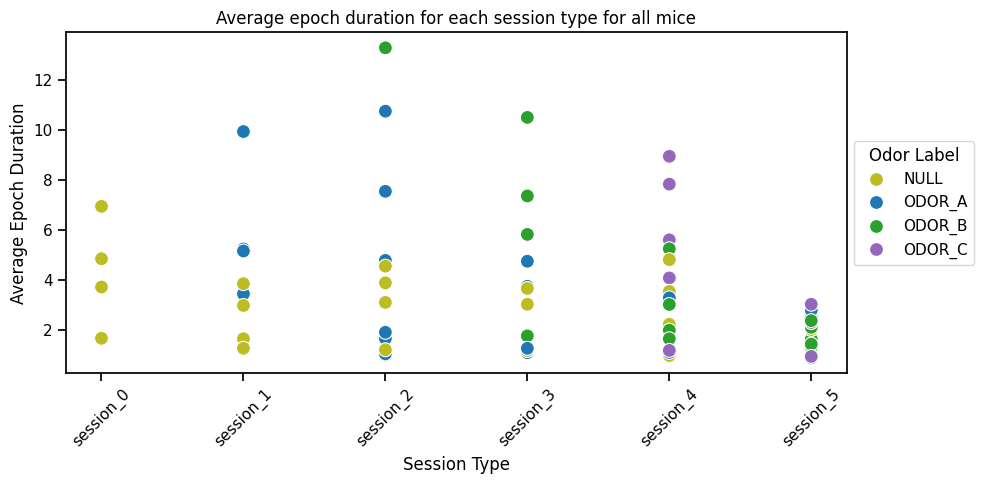

In [11]:
#make big df for all mice
all_mice = pd.concat(mouse_dfs)
all_mice

#plot scatterplot for all mice, add lines connecting the same odor label
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(data=all_mice, x='session_type', y='average_epoch_duration', hue='odor_label', palette=odor_list_color, s=100)
plt.title("Average epoch duration for each session type for all mice")
plt.xlabel('Session Type')
plt.ylabel('Average Epoch Duration')
plt.xticks(rotation=45)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Odor Label')
plt.tight_layout()
plt.grid(False)
plt.show()
plt.close()


In [12]:
all_mice

,mouse_id,session_type,odor_label,average_epoch_duration
0,717716,session_0,NULL,4.842016
1,717716,session_1,NULL,1.258976
2,717716,session_1,ODOR_A,1.226016
3,717716,session_2,NULL,0.984000
4,717716,session_2,ODOR_A,1.026016
...,...,...,...,...
78,745306,session_4,ODOR_C,8.948992
79,745306,session_5,NULL,2.792000
80,745306,session_5,ODOR_A,2.775008
81,745306,session_5,ODOR_B,2.359008


In [13]:
#see if there are any differences in the average epoch duration for each session type for each mouse in all_mice
#use ANOVA to test for differences
import statsmodels.api as sm
from statsmodels.formula.api import ols
# Perform ANOVA
model = ols('average_epoch_duration ~ session_type * mouse_id', data=all_mice).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

# Print ANOVA table
print(anova_table)

                           sum_sq    df          F    PR(>F)
session_type            73.147429   5.0   2.826066  0.021989
mouse_id                70.864304   1.0  13.689286  0.000422
session_type:mouse_id   28.692601   5.0   1.108545  0.363665
Residual               367.540392  71.0        NaN       NaN


In [14]:
#compare session_4 and session_5 for each mouse
# Perform ANOVA
model = ols('average_epoch_duration ~ session_type', data=all_mice).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

# Print ANOVA table
print(anova_table)


                  sum_sq    df         F    PR(>F)
session_type   71.463372   5.0  2.356117  0.048087
Residual      467.097297  77.0       NaN       NaN


p<0.05.... difference between session types! what is that difference now...

In [15]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Fit the model
model = ols('average_epoch_duration ~ session_type', data=all_mice).fit()

# Perform ANOVA
anova_results = sm.stats.anova_lm(model, typ=2)

# Perform Tukey's HSD test
tukey = pairwise_tukeyhsd(endog=all_mice['average_epoch_duration'], 
                          groups=all_mice['session_type'], 
                          alpha=0.05)

print(tukey)


#just session 2 and session5.. hmm

   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1    group2  meandiff p-adj   lower   upper  reject
----------------------------------------------------------
session_0 session_1  -0.8031 0.9911 -4.7459  3.1397  False
session_0 session_2   0.1544    1.0 -3.6773  3.9861  False
session_0 session_3  -0.6281 0.9968 -4.4598  3.2036  False
session_0 session_4  -1.0141 0.9623 -4.6133  2.5852  False
session_0 session_5  -2.4361 0.3452 -5.9749  1.1027  False
session_1 session_2   0.9575 0.9433 -2.1247  4.0398  False
session_1 session_3    0.175    1.0 -2.9072  3.2573  False
session_1 session_4  -0.2109 0.9999 -2.9989   2.577  False
session_1 session_5   -1.633 0.4963 -4.3424  1.0764  False
session_2 session_3  -0.7825 0.9704 -3.7213  2.1563  False
session_2 session_4  -1.1685 0.7846  -3.797  1.4601  False
session_2 session_5  -2.5905 0.0436 -5.1356 -0.0455   True
session_3 session_4   -0.386 0.9981 -3.0145  2.2426  False
session_3 session_5   -1.808 0.3105 -4.3531   0.737  Fal

In [16]:
from scipy.stats import ttest_ind

# Filter data for session_4 and session_5
session_4_data = all_mice[all_mice['session_type'] == 'session_4']['average_epoch_duration']
session_5_data = all_mice[all_mice['session_type'] == 'session_5']['average_epoch_duration']

# Perform t-test
t_stat, p_value = ttest_ind(session_4_data, session_5_data)

print(f"T-Statistic: {t_stat}, P-Value: {p_value}")

#statistically significant difference between session_4 and session_5!!!

T-Statistic: 2.8758387227454487, P-Value: 0.006303529082771357


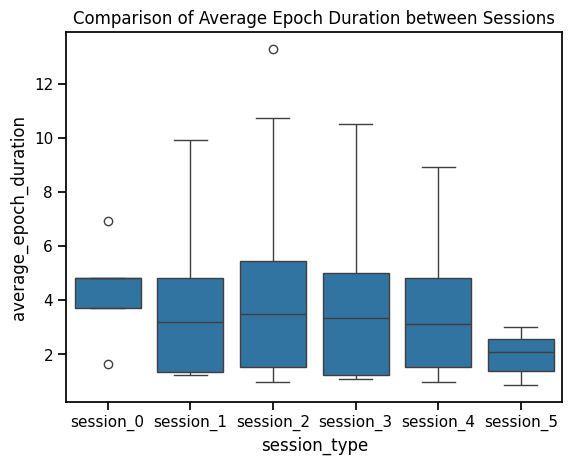

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a boxplot
sns.boxplot(x='session_type', y='average_epoch_duration', data=all_mice)
plt.title('Comparison of Average Epoch Duration between Sessions')
plt.show()

In [18]:
import pandas as pd
from scipy import stats
#session 4 and 5
# Filter data for sessions 4 and 5
sessions_of_interest = ['session_4', 'session_5']
filtered_df = all_mice[all_mice['session_type'].isin(sessions_of_interest)]

# Initialize a dictionary to store results
results = []

# Get the unique odor labels
odor_labels = filtered_df['odor_label'].unique()

# Iterate through each odor label
for odor_label in odor_labels:
    # Filter data for the specific odor label
    odor_df = filtered_df[filtered_df['odor_label'] == odor_label]
    
    # Separate the data for sessions 4 and 5
    session_4_data = odor_df[odor_df['session_type'] == 'session_4']['average_epoch_duration']
    session_5_data = odor_df[odor_df['session_type'] == 'session_5']['average_epoch_duration']
    
    # Check if there is data for both sessions
    if not session_4_data.empty and not session_5_data.empty:
        # Perform the t-test
        t_stat, p_value = stats.ttest_ind(session_4_data, session_5_data, equal_var=False)
        
        # Store the results
        results.append({
            'odor_label': odor_label,
            't_statistic': t_stat,
            'p_value': p_value
        })

# Convert results to a DataFrame
session45_df = pd.DataFrame(results)

# Print results
print(session45_df)

  odor_label  t_statistic   p_value
0       NULL     0.737683  0.490158
1     ODOR_A     0.727812  0.495425
2     ODOR_B     1.661052  0.156135
3     ODOR_C     2.370498  0.070045


In [19]:

import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Assuming 'df' is your DataFrame with 'average_epoch_duration' and 'odor_label'
X = all_mice[['average_epoch_duration']]  # Features
y = all_mice['odor_label']  # Target

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Train the Random Forest model
model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_train_resampled, y_train_resampled)

# Evaluate the model on the test set
y_pred = model.predict(X_test)

# Accuracy and Classification Report
print(f"Accuracy: {model.score(X_test, y_test):.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=df['odor_label'].unique())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=df['odor_label'].unique())
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Cross-validated accuracy
cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print(f"Cross-validated accuracy: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}")

# Learning Curves
train_sizes, train_scores, test_scores = learning_curve(model, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy')

plt.figure(figsize=(12, 6))
plt.plot(train_sizes, train_scores.mean(axis=1), 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores.mean(axis=1), 'o-', color='g', label='Cross-validation score')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.title('Learning Curves')
plt.legend()
plt.show()


ModuleNotFoundError: No module named 'imblearn'

# Differences
for NULL, ODOR_A, and ODOR_B, there is no statistically significant difference in average_epoch_duration between sessions 4 and 5.


possible Trend: For ODOR_C, while not statistically significant at the 0.05 level, the p-value is close to 0.05, indicating a potential trend towards significance.

# load in marinas df

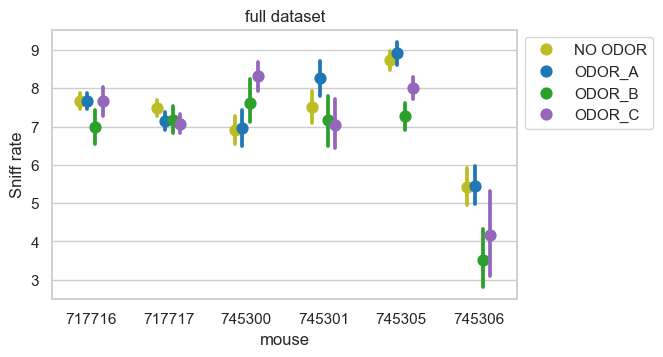

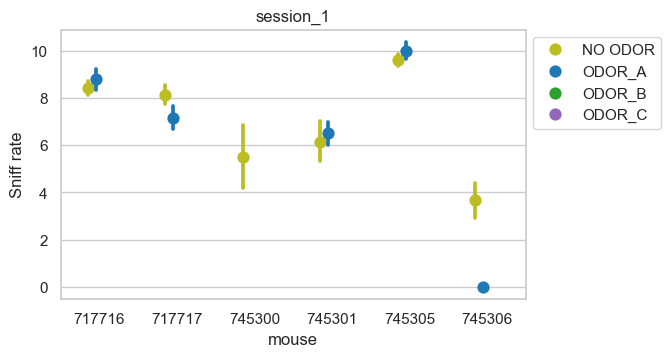

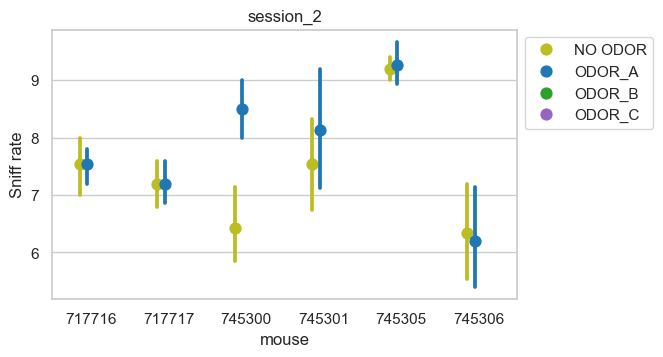

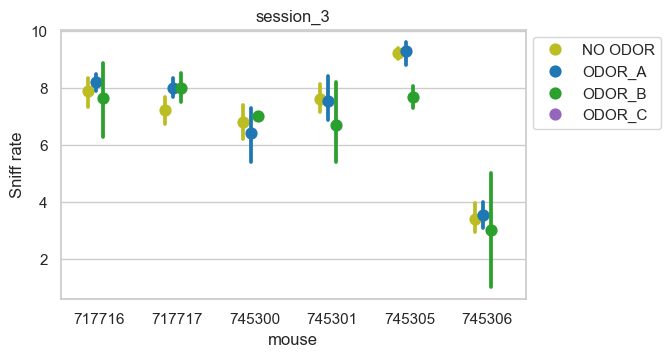

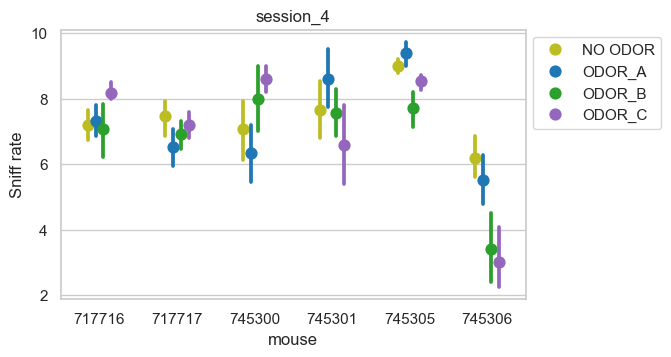

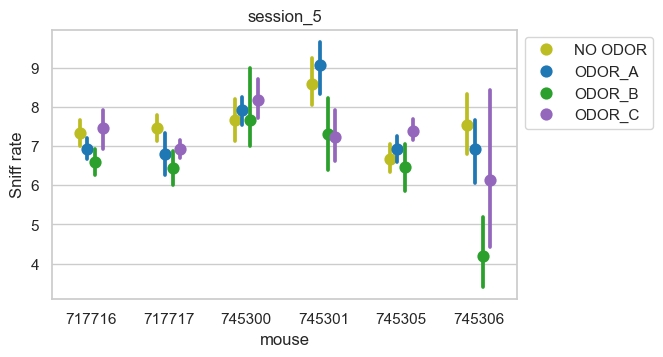

In [ ]:
#merged_df

data = pd.read_csv('/Users/nehal.ajmal/Downloads/merged_filtered_df.csv')

metric = 'peak_count_after_1s'
ylabel = 'Sniff rate'

odor_labels = np.sort(data.odor_label.unique())
# plot for all data
fig, ax = plt.subplots(figsize=(6, 3.5))
ax = sns.pointplot(data=data, x='mouse', y=metric, 
                    hue='odor_label', hue_order=odor_labels, palette=odor_list_color, 
                    join=False, dodge=0.3, ax=ax)
ax.set_ylabel(ylabel)
ax.set_title('full dataset')
ax.legend(bbox_to_anchor=(1,1))

# plot each session type
for session_type in data.session_type.unique():
    fig, ax = plt.subplots(figsize=(6, 3.5))
    ax = sns.pointplot(data=data[data.session_type==session_type], x='mouse', y=metric, 
                       hue='odor_label', hue_order=odor_labels, palette=odor_list_color, 
                       join=False, dodge=0.3, ax=ax)
    ax.set_ylabel(ylabel)
    ax.set_title(session_type)
    ax.legend(bbox_to_anchor=(1,1))



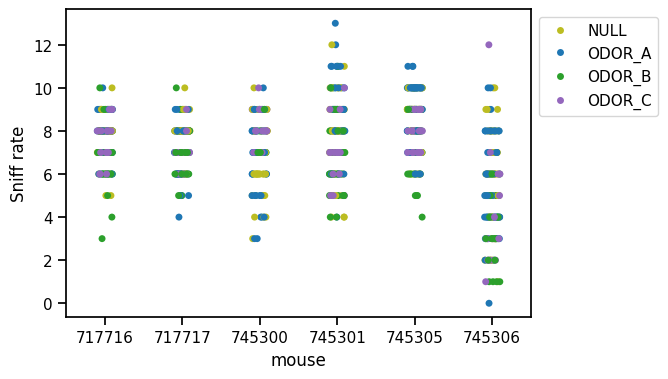

In [ ]:
odor_labels = np.sort(data.odor_label.unique())
fig, ax = plt.subplots(figsize=(6,4))
ax = sns.stripplot(data=data, x='mouse', y='peak_count_after_1s', hue='odor_label', 
                   hue_order=odor_labels, palette=odor_list_color, ax=ax)
ax.set_ylabel('Sniff rate')
ax.legend(bbox_to_anchor=(1,1))

### Compare the two methods of computing time in site


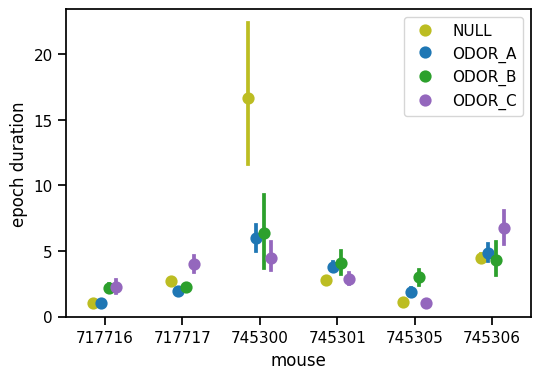

In [ ]:
# nehal's column for site duration is 'epoch_duration'
odor_labels = np.sort(data.odor_label.unique())
fig, ax = plt.subplots(figsize=(6,4))
ax = sns.pointplot(data=data, x='mouse', y='epoch_duration', hue='odor_label', 
                   hue_order=odor_labels, palette=odor_list_color, 
                   join=False, dodge=0.3, ax=ax)
ax.set_ylabel('epoch duration')
ax.legend(bbox_to_anchor=(1,1))

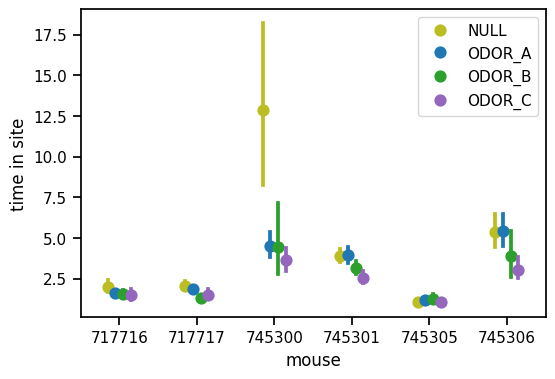

In [ ]:
# Alexia's column for site duration is "time in site"
odor_labels = np.sort(data.odor_label.unique())
fig, ax = plt.subplots(figsize=(6,4))
ax = sns.pointplot(data=data, x='mouse', y='time_in_site', hue='odor_label', 
                   hue_order=odor_labels, palette=odor_list_color, 
                   join=False, dodge=0.3, ax=ax)
ax.set_ylabel('time in site')
ax.legend(bbox_to_anchor=(1,1))

Looks pretty similar. Need to filter out outliers though

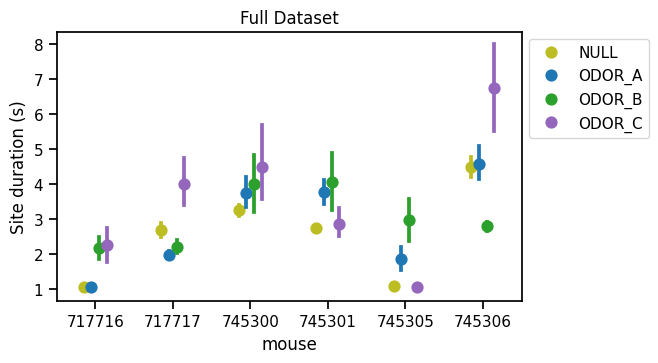

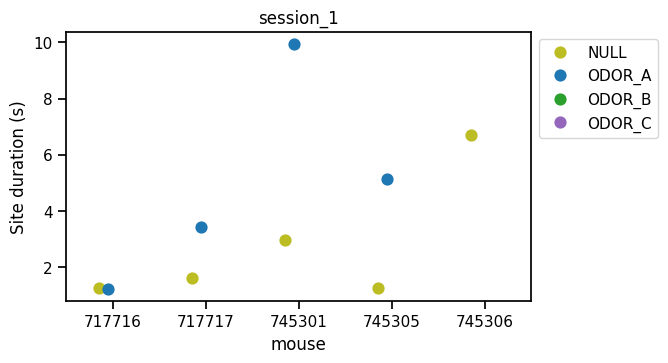

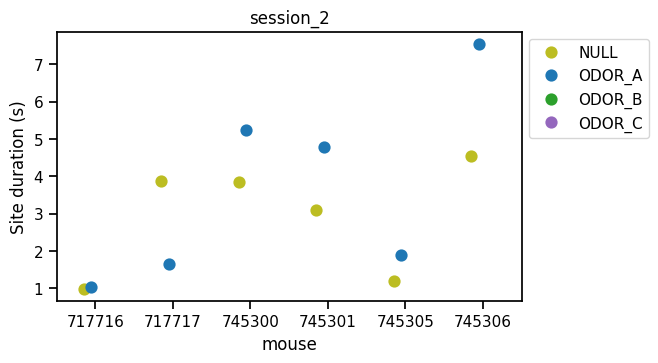

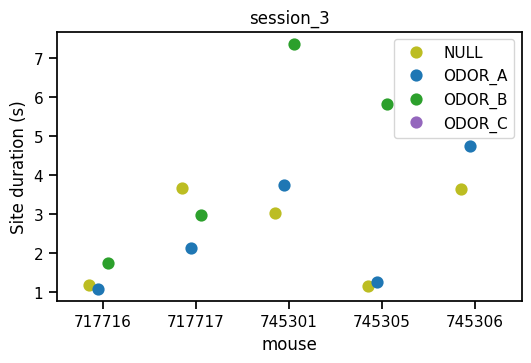

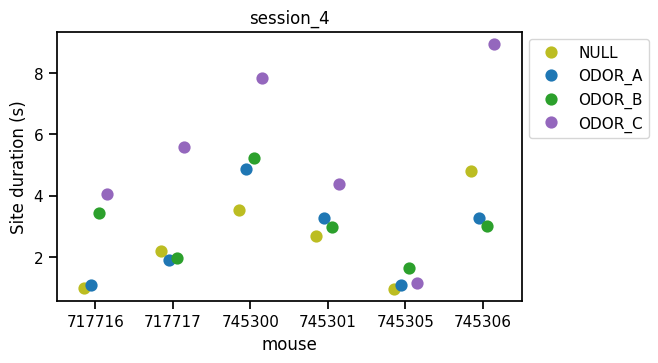

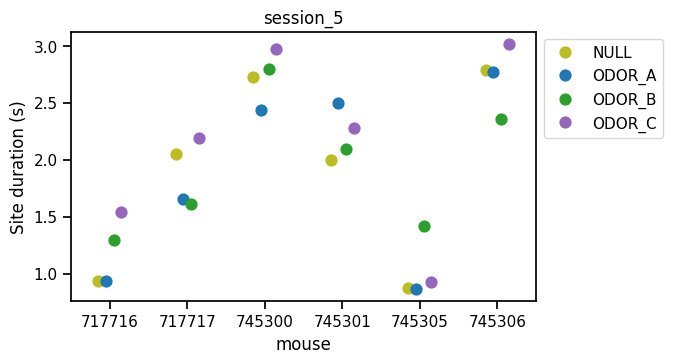

In [ ]:
metric = 'epoch_duration'
ylabel = 'Site duration (s)'

odor_labels = np.sort(data.odor_label.unique())

# remove outliers
site_data = data[data.epoch_duration<10]

# plot for all data
fig, ax = plt.subplots(figsize=(6, 3.5))
ax = sns.pointplot(data=site_data, x='mouse', y=metric, 
                    hue='odor_label', hue_order=odor_labels, palette=odor_list_color, 
                    join=False, dodge=0.3, ax=ax)
ax.set_ylabel(ylabel)
ax.set_title('Full Dataset')
ax.legend(bbox_to_anchor=(1,1))

# plot each session type
for session_type in data.session_type.unique():
    fig, ax = plt.subplots(figsize=(6, 3.5))
    ax = sns.pointplot(data=site_data[site_data.session_type==session_type], x='mouse', y=metric, 
                       hue='odor_label', hue_order=odor_labels, palette=odor_list_color, 
                       join=False, dodge=0.3, ax=ax)
    ax.set_ylabel(ylabel)
    ax.set_title(session_type)
    ax.legend(bbox_to_anchor=(1,1))



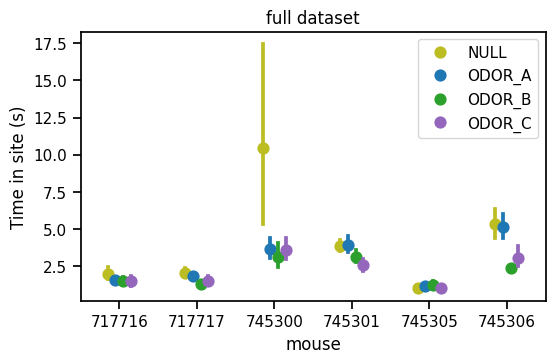

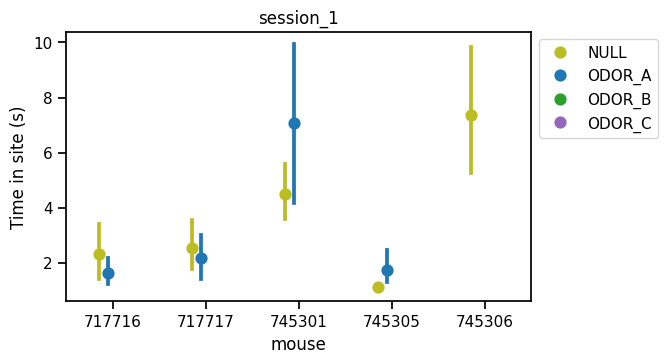

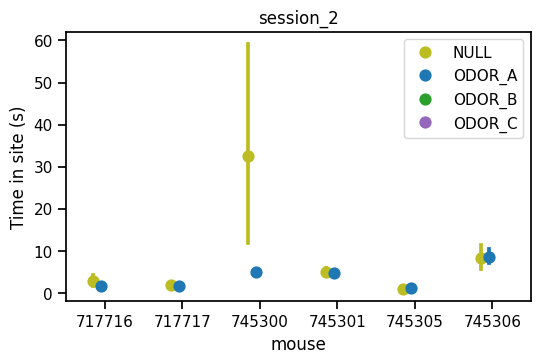

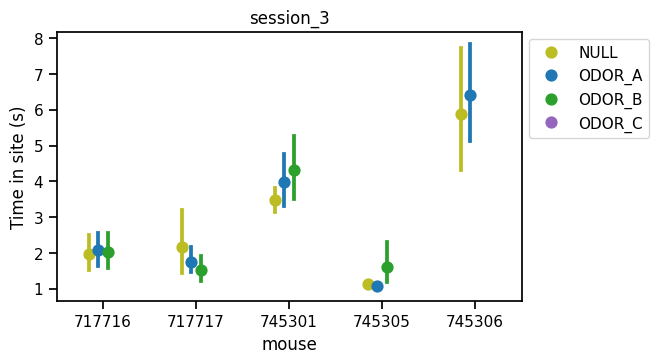

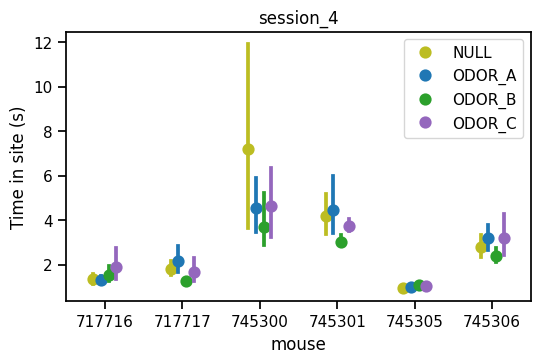

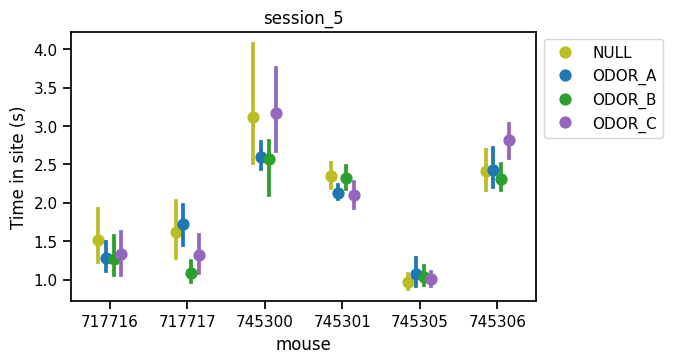

In [ ]:
metric = 'time_in_site'
ylabel = 'Time in site (s)'

odor_labels = np.sort(data.odor_label.unique())

# remove outliers
site_data = data[data.epoch_duration<10]

# plot for all data
fig, ax = plt.subplots(figsize=(6, 3.5))
ax = sns.pointplot(data=site_data, x='mouse', y=metric, 
                    hue='odor_label', hue_order=odor_labels, palette=odor_list_color, 
                    join=False, dodge=0.3, ax=ax)
ax.set_ylabel(ylabel)
ax.set_title('full dataset')
ax.legend(bbox_to_anchor=(1,1))

# plot each session type
for session_type in data.session_type.unique():
    fig, ax = plt.subplots(figsize=(6, 3.5))
    ax = sns.pointplot(data=site_data[site_data.session_type==session_type], x='mouse', y=metric, 
                       hue='odor_label', hue_order=odor_labels, palette=odor_list_color, 
                       join=False, dodge=0.3, ax=ax)
    ax.set_ylabel(ylabel)
    ax.set_title(session_type)
    ax.legend(bbox_to_anchor=(1,1))



# for more than 10 sites

In [ ]:
all_files = glob.glob('/Users/nehal.ajmal/Documents/aindproject/results/*.csv')

#make each csv into a dataframe and concatenate them
li = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)

#make a column for mouse_id
frame['mouse_id'] = frame['session'].str[:6]

#replace Nan with NULL label
frame['odor_label'] = frame['odor_label'].replace(np.nan, 'NULL')
frame


,session,odor_label,odor_site,peak_count,peak_frequency,epoch_duration,peak_count_after_1s,session_type,mouse_id
0,717717_20240723T161400,NULL,0.0,40,7.792726,5.132992,9,NaN,717717
1,717717_20240723T161400,NULL,1.0,40,7.792726,5.132992,8,NaN,717717
2,717717_20240723T161400,NULL,2.0,39,7.597908,5.132992,9,NaN,717717
3,717717_20240723T161400,NULL,3.0,44,8.571999,5.132992,7,NaN,717717
4,717717_20240723T161400,NULL,4.0,39,7.597908,5.132992,7,NaN,717717
...,...,...,...,...,...,...,...,...,...
5558,745301_20240803T123112,ODOR_C,58.0,16,7.011443,2.281984,6,NaN,745301
5559,745301_20240803T123112,ODOR_C,73.0,16,7.011443,2.281984,7,NaN,745301
5560,745301_20240803T123112,ODOR_C,76.0,14,6.135012,2.281984,5,NaN,745301
5561,745301_20240803T123112,ODOR_C,84.0,17,7.449658,2.281984,7,NaN,745301


In [ ]:

#remove all epoch_duration values that are over 15s
frame = frame[frame['epoch_duration'] <= 15]
frame

#save df to csv in /Users/nehal.ajmal/Documents/aindproject/results2
frame.to_csv(f'/Users/nehal.ajmal/Documents/aindproject/results2/all_peaks_data.csv', index=False)


#load in the csv
frame = pd.read_csv(f'/Users/nehal.ajmal/Documents/aindproject/results2/all_peaks_data.csv')
#replace Nan with NULL label
frame['odor_label'] = frame['odor_label'].replace(np.nan, 'NULL')
frame

# Group by 'session' and get unique 'odor_label'
unique_odor_labels_per_session = frame.groupby('session')['odor_label'].unique().reset_index()

unique_odor_labels_per_session


,session,odor_label
0,717716_20240710T110945,[ODOR_B]
1,717716_20240712T151051,[NULL]
2,717716_20240713T111905,[NULL]
3,717716_20240715T094102,"[NULL, ODOR_A]"
4,717716_20240716T092600,"[NULL, ODOR_A]"
...,...,...
57,745306_20240730T102416,[NULL]
58,745306_20240731T100050,"[NULL, ODOR_A]"
59,745306_20240801T100355,"[NULL, ODOR_A, ODOR_B]"
60,745306_20240802T100131,"[NULL, ODOR_A, ODOR_C, ODOR_B]"
